In [1]:
import sys
from torch.utils.data import random_split
sys.path.append("../")

In [2]:
from datasets import datasets
import pickle
import os
import pandas
from PIL import Image
import matplotlib.pyplot as plt
import numpy
import cv2
import torch

Loading training set information from the CSV file

In [3]:
train_info = pandas.read_csv("../data/raw_data/train.csv")

Loading images from folders

In [4]:
images = []

for path in os.listdir("../data/raw_data/train_images"):
    img_file = os.path.join("../data/raw_data/train_images", path)
    images.append(img_file)

train_info['image'] = images

Representing number of images for each individual class

In [5]:
train_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
 2   image   19906 non-null  object
dtypes: object(3)
memory usage: 466.7+ KB


In [6]:
train_info.rename(
    columns={
        "Class": "class",
        "ID": "id"
    }, inplace=True
)

In [7]:
train_info['class'].value_counts()

class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

In [8]:
train_info['class'] = train_info['class'].map(
    {
        'YOUNG': 0,
        'MIDDLE': 1,
        'OLD': 2
    }
)

In [9]:
train_info['class']

0        1
1        0
2        1
3        0
4        1
        ..
19901    1
19902    0
19903    1
19904    1
19905    1
Name: class, Length: 19906, dtype: int64

In [10]:
%%time

def to_png(img):
    success, png_data = cv2.imencode('.png', numpy.array(img))
    if success == True:
        png_image = cv2.imdecode(png_data, cv2.IMREAD_UNCHANGED)
        return Image.fromarray(png_image)
    else:
        print('sdffdss')
        raise RuntimeError('conversion failed')
        
def to_rgb(img):
    file = Image.open(img)
    if numpy.array(file).shape[2] == 4:
        file = cv2.cvtColor(numpy.array(file), cv2.COLOR_BGRA2BGR)
        file = Image.fromarray(file)
    return to_png(file)

imgs = train_info['image']
train_info['image'] = imgs.apply(lambda img: to_rgb(img))

CPU times: user 21.7 s, sys: 676 ms, total: 22.4 s
Wall time: 25.1 s


In [11]:
train_info['image']

0        <PIL.Image.Image image mode=RGB size=53x77 at ...
1        <PIL.Image.Image image mode=RGB size=34x56 at ...
2        <PIL.Image.Image image mode=RGB size=64x82 at ...
3        <PIL.Image.Image image mode=RGB size=57x73 at ...
4        <PIL.Image.Image image mode=RGB size=37x76 at ...
                               ...                        
19901    <PIL.Image.Image image mode=RGB size=46x58 at ...
19902    <PIL.Image.Image image mode=RGB size=159x156 a...
19903    <PIL.Image.Image image mode=RGB size=29x39 at ...
19904    <PIL.Image.Image image mode=RGB size=121x161 a...
19905    <PIL.Image.Image image mode=RGB size=38x41 at ...
Name: image, Length: 19906, dtype: object

# Resizing images

In [12]:
HEIGHT = 512
WIDTH = 512

In [13]:
train_info['image'] = train_info['image'].apply(
    lambda image: cv2.resize(
        numpy.array(image), 
        (HEIGHT, WIDTH), 
        interpolation=cv2.INTER_CUBIC
    )
)

# Evaluating and filtering out high quality images

In [142]:
import numpy
def estimate_noise_level(image: numpy.ndarray, window_size: int = 30):
    """
    Function estimates noise level 
    for given image

    Args:
        image - (numpy.ndarray) - image
        window_size - size of the blurring kernel
    Returns:
        - mean std of the image
    """
    if not image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    std = cv2.blur(image**2, (window_size, window_size)) - cv2.blur(image, (window_size, window_size))**2
    std[std < 0] = 0
    std = numpy.sqrt(std)
    mean_std = numpy.mean(std)
    return mean_std

# Selecting first 8000 images with the highest quality

In [143]:
%%time

images = train_info['image'].tolist()

sorted_qual_idxs = sorted(
    range(len(images)), 
    key=lambda idx: estimate_noise_level(numpy.array(images[idx]))
)[:8000]

CPU times: user 54.1 s, sys: 7.77 s, total: 1min 1s
Wall time: 1min 37s


# Forming data augmentation instructions

In [144]:
from torchvision import transforms 
from PIL import Image

train_transformations = [
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.RandomAdjustSharpness(sharpness_factor=1.3, p=0.5),
    transforms.Normalize(mean=([0.485, 0.456, 0.406]), std = [0.229, 0.224, 0.225])
]

eval_transformations = [
    transforms.ToTensor()
]

# Splitting data into training and evaludation set using Stratified Sampling

In [145]:
from sklearn.model_selection import train_test_split

labels = train_info.iloc[sorted_qual_idxs]['class'].tolist()

train_d, test_d = train_test_split(
    sorted_qual_idxs,
    test_size=int(len(labels) * 0.3),
    stratify=labels
)

# Handling class disbalance by defining class weights

In [146]:
CLASS_WEIGHTS = torch.tensor(
    [
        1.0,
        1.5,
        2.0
    ]
)

# Splitting data

In [147]:
# training set
train_dataset = datasets.FaceRecognitionDataset(
    images=numpy.array(train_info['image'])[train_d],
    labels=numpy.array(train_info['class'])[train_d],
    transformations=train_transformations,
    weights=CLASS_WEIGHTS,
)

# evaludation dataset
eval_dataset = datasets.FaceRecognitionDataset(
    images=numpy.array(train_info['image'])[test_d],
    labels=numpy.array(train_info['class'])[test_d],
    transformations=eval_transformations,
    weights=CLASS_WEIGHTS
)

In [148]:
len(train_dataset.labels)

5600

# Image Enhancement

In [149]:
def histogram_equalization(img: numpy.ndarray):
    """
    Enhancing image using histogram equalization
    technique
    """
    r, g, b = cv2.split(img)
    new_r = cv2.equalizeHist(src=r)
    new_g = cv2.equalizeHist(src=g)
    new_b = cv2.equalizeHist(src=b)
    new_img = cv2.merge((new_r, new_g, new_b))
    return new_img

def gamma_correction(img: numpy.ndarray, gamma: float):
    """
    Enhancing quality and contrast of the given image
    using gamma correction algorithm

    gamma > 1 - brightening 
    gamma = 1 - no change 
    gamme < 1 - darkening
    """
    normalized_img = numpy.power(img / 255.0, gamma) * 255.0
    new_img = numpy.clip(normalized_img, 0, 255).astype(numpy.uint8)
    return new_img

In [150]:
from tqdm import tqdm

idx = 0
gamma = 1.2

for image in tqdm(train_dataset.images):
    train_dataset.images[idx] = histogram_equalization(numpy.array(image))
    train_dataset.images[idx] = gamma_correction(numpy.array(image), gamma=gamma)
    idx = idx + 1

100%|███████████████████████████████████████| 5600/5600 [01:03<00:00, 87.80it/s]


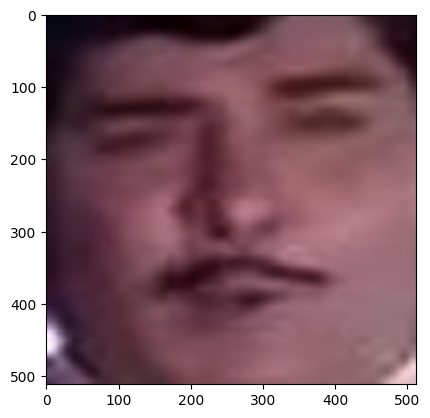

In [178]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.images[211])

# Saving datasets to pickle format

In [179]:
pickle.dump(obj=train_dataset, file=open("../data/augmented_data/testing_set.pkl", mode='wb'))

In [180]:
pickle.dump(obj=eval_dataset, file=open("../data/augmented_data/training_set.pkl", mode='wb'))